In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from typing import List, Optional, Tuple, Union

import math
import random

import time
import json

In [2]:
!pip install transformers

     ---------------------------------------- 5.8/5.8 MB 3.7 MB/s eta 0:00:00
     ------------------------------------ 182.4/182.4 kB 647.4 kB/s eta 0:00:00
     ---------------------------------------- 3.3/3.3 MB 3.5 MB/s eta 0:00:00
     -------------------------------------- 151.7/151.7 kB 3.0 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Model part 1

In [3]:
from typing import Optional
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class TokenImportancesExtractor(nn.Module):

    def __init__(self, model_name):
        super().__init__()

        #self.encoder = AutoModel.from_pretrained(model_name)

        self.decoder = AutoModel.from_pretrained(model_name)
        #self.decoder.config.add_cross_attention=True

        self.linear = nn.Linear(self.decoder.config.hidden_size, 1)


    def forward(self, 
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None
        ):

        decoder_outputs = self.decoder(
            input_ids = input_ids,
            attention_mask = attention_mask
        )

        decoder_hidden_states = decoder_outputs[0]

        logits = self.linear(decoder_hidden_states)

        return nn.functional.sigmoid(logits) 

## Model part 2

In [4]:
import gc
import os
import tempfile
import warnings
from typing import Optional, Tuple, Union

import torch
from torch import nn
from torch.nn import CrossEntropyLoss


from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_outputs import BaseModelOutput, Seq2SeqLMOutput
from transformers.modeling_utils import PreTrainedModel
from transformers.utils import add_start_docstrings, add_start_docstrings_to_model_forward, logging, replace_return_docstrings
from transformers.models.auto.configuration_auto import AutoConfig
from transformers.models.auto.modeling_auto import AutoModel, AutoModelForCausalLM
from transformers.models.encoder_decoder.configuration_encoder_decoder import EncoderDecoderConfig

from transformers.models.encoder_decoder.modeling_encoder_decoder import DEPRECATION_WARNING, shift_tokens_right


def forward_encdec(
    self,
    input_ids: Optional[torch.LongTensor] = None,
    token_importances: Optional[torch.LongTensor] = None,
    attention_mask: Optional[torch.FloatTensor] = None,
    decoder_input_ids: Optional[torch.LongTensor] = None,
    decoder_attention_mask: Optional[torch.BoolTensor] = None,
    encoder_outputs: Optional[Tuple[torch.FloatTensor]] = None,
    past_key_values: Tuple[Tuple[torch.FloatTensor]] = None,
    inputs_embeds: Optional[torch.FloatTensor] = None,
    decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
    labels: Optional[torch.LongTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
    **kwargs,
) -> Union[Tuple, Seq2SeqLMOutput]:
    r"""
    Returns:
    Examples:
    ```python
    >>> from transformers import EncoderDecoderModel, BertTokenizer
    >>> import torch
    >>> tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    >>> model = EncoderDecoderModel.from_encoder_decoder_pretrained(
    ...     "bert-base-uncased", "bert-base-uncased"
    ... )  # initialize Bert2Bert from pre-trained checkpoints
    >>> # training
    >>> model.config.decoder_start_token_id = tokenizer.cls_token_id
    >>> model.config.pad_token_id = tokenizer.pad_token_id
    >>> model.config.vocab_size = model.config.decoder.vocab_size
    >>> input_ids = tokenizer("This is a really long text", return_tensors="pt").input_ids
    >>> labels = tokenizer("This is the corresponding summary", return_tensors="pt").input_ids
    >>> outputs = model(input_ids=input_ids, labels=labels)
    >>> loss, logits = outputs.loss, outputs.logits
    >>> # save and load from pretrained
    >>> model.save_pretrained("bert2bert")
    >>> model = EncoderDecoderModel.from_pretrained("bert2bert")
    >>> # generation
    >>> generated = model.generate(input_ids)
    ```"""

    return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    kwargs_encoder = {argument: value for argument, value in kwargs.items() if not argument.startswith("decoder_")}

    kwargs_decoder = {
        argument[len("decoder_") :]: value for argument, value in kwargs.items() if argument.startswith("decoder_")
    }

    if encoder_outputs is None:
        encoder_outputs = self.encoder(
            input_ids=input_ids,
            token_importances=token_importances,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            **kwargs_encoder,
        )
    elif isinstance(encoder_outputs, tuple):
        encoder_outputs = BaseModelOutput(*encoder_outputs)

    encoder_hidden_states = encoder_outputs[0]

    # optionally project encoder_hidden_states
    if (
        self.encoder.config.hidden_size != self.decoder.config.hidden_size
        and self.decoder.config.cross_attention_hidden_size is None
    ):
        encoder_hidden_states = self.enc_to_dec_proj(encoder_hidden_states)

    if (labels is not None) and (decoder_input_ids is None and decoder_inputs_embeds is None):
        decoder_input_ids = shift_tokens_right(
            labels, self.config.pad_token_id, self.config.decoder_start_token_id
        )

    # Decode
    decoder_outputs = self.decoder(
        input_ids=decoder_input_ids,
        attention_mask=decoder_attention_mask,
        encoder_hidden_states=encoder_hidden_states,
        encoder_attention_mask=attention_mask,
        inputs_embeds=decoder_inputs_embeds,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        use_cache=use_cache,
        past_key_values=past_key_values,
        return_dict=return_dict,
        **kwargs_decoder,
    )

    # Compute loss independent from decoder (as some shift the logits inside them)
    loss = None
    if labels is not None:
        warnings.warn(DEPRECATION_WARNING, FutureWarning)
        logits = decoder_outputs.logits if return_dict else decoder_outputs[0]
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.reshape(-1, self.decoder.config.vocab_size), labels.view(-1))

    if not return_dict:
        if loss is not None:
            return (loss,) + decoder_outputs + encoder_outputs
        else:
            return decoder_outputs + encoder_outputs

    return Seq2SeqLMOutput(
        loss=loss,
        logits=decoder_outputs.logits,
        past_key_values=decoder_outputs.past_key_values,
        decoder_hidden_states=decoder_outputs.hidden_states,
        decoder_attentions=decoder_outputs.attentions,
        cross_attentions=decoder_outputs.cross_attentions,
        encoder_last_hidden_state=encoder_outputs.last_hidden_state,
        encoder_hidden_states=encoder_outputs.hidden_states,
        encoder_attentions=encoder_outputs.attentions,
    )

In [5]:
import math
from typing import List, Optional, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.activations import ACT2FN, gelu
from transformers.modeling_outputs import (
    BaseModelOutputWithPastAndCrossAttentions,
    BaseModelOutputWithPoolingAndCrossAttentions,
    CausalLMOutputWithCrossAttentions,
    MaskedLMOutput,
    MultipleChoiceModelOutput,
    QuestionAnsweringModelOutput,
    SequenceClassifierOutput,
    TokenClassifierOutput,
)
from transformers.modeling_utils import PreTrainedModel
from transformers.pytorch_utils import apply_chunking_to_forward, find_pruneable_heads_and_indices, prune_linear_layer
from transformers.utils import (
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    logging,
    replace_return_docstrings,
)
from transformers.models.roberta.configuration_roberta import RobertaConfig

def forward_enc(
    self,
    input_ids: Optional[torch.Tensor] = None,
    token_importances: Optional[torch.LongTensor] = None,
    attention_mask: Optional[torch.Tensor] = None,
    token_type_ids: Optional[torch.Tensor] = None,
    position_ids: Optional[torch.Tensor] = None,
    head_mask: Optional[torch.Tensor] = None,
    inputs_embeds: Optional[torch.Tensor] = None,
    encoder_hidden_states: Optional[torch.Tensor] = None,
    encoder_attention_mask: Optional[torch.Tensor] = None,
    past_key_values: Optional[List[torch.FloatTensor]] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPoolingAndCrossAttentions]:
    r"""
    encoder_hidden_states  (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
        Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
        the model is configured as a decoder.
    encoder_attention_mask (`torch.FloatTensor` of shape `(batch_size, sequence_length)`, *optional*):
        Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
        the cross-attention if the model is configured as a decoder. Mask values selected in `[0, 1]`:
        - 1 for tokens that are **not masked**,
        - 0 for tokens that are **masked**.
    past_key_values (`tuple(tuple(torch.FloatTensor))` of length `config.n_layers` with each tuple having 4 tensors of shape `(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
        Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.
        If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those that
        don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of all
        `decoder_input_ids` of shape `(batch_size, sequence_length)`.
    use_cache (`bool`, *optional*):
        If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding (see
        `past_key_values`).
    """
    output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
    output_hidden_states = (
        output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
    )
    return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    if self.config.is_decoder:
        use_cache = use_cache if use_cache is not None else self.config.use_cache
    else:
        use_cache = False

    if input_ids is not None and inputs_embeds is not None:
        raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
    elif input_ids is not None:
        input_shape = input_ids.size()
    elif inputs_embeds is not None:
        input_shape = inputs_embeds.size()[:-1]
    else:
        raise ValueError("You have to specify either input_ids or inputs_embeds")

    batch_size, seq_length = input_shape
    device = input_ids.device if input_ids is not None else inputs_embeds.device

    # past_key_values_length
    past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

    if attention_mask is None:
        attention_mask = torch.ones(((batch_size, seq_length + past_key_values_length)), device=device)

    if token_type_ids is None:
        if hasattr(self.embeddings, "token_type_ids"):
            buffered_token_type_ids = self.embeddings.token_type_ids[:, :seq_length]
            buffered_token_type_ids_expanded = buffered_token_type_ids.expand(batch_size, seq_length)
            token_type_ids = buffered_token_type_ids_expanded
        else:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

    # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
    # ourselves in which case we just need to make it broadcastable to all heads.
    extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape)

    # If a 2D or 3D attention mask is provided for the cross-attention
    # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
    if self.config.is_decoder and encoder_hidden_states is not None:
        encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
        encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
        if encoder_attention_mask is None:
            encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
        encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
    else:
        encoder_extended_attention_mask = None

    # Prepare head mask if needed
    # 1.0 in head_mask indicate we keep the head
    # attention_probs has shape bsz x n_heads x N x N
    # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
    # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
    head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

    embedding_output = self.embeddings(
        input_ids=input_ids,
        position_ids=position_ids,
        token_type_ids=token_type_ids,
        inputs_embeds=inputs_embeds,
        past_key_values_length=past_key_values_length,
    )
    
    encoder_outputs = self.encoder(
        embedding_output,
        token_importances=token_importances,
        attention_mask=extended_attention_mask,
        head_mask=head_mask,
        encoder_hidden_states=encoder_hidden_states,
        encoder_attention_mask=encoder_extended_attention_mask,
        past_key_values=past_key_values,
        use_cache=use_cache,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
    )
    sequence_output = encoder_outputs[0]
    pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

    if not return_dict:
        return (sequence_output, pooled_output) + encoder_outputs[1:]

    return BaseModelOutputWithPoolingAndCrossAttentions(
        last_hidden_state=sequence_output,
        pooler_output=pooled_output,
        past_key_values=encoder_outputs.past_key_values,
        hidden_states=encoder_outputs.hidden_states,
        attentions=encoder_outputs.attentions,
        cross_attentions=encoder_outputs.cross_attentions,
    )

In [6]:
logger = logging.get_logger(__name__)

def forward_enc_enc(
    self,
    hidden_states: torch.Tensor,
    token_importances: Optional[torch.LongTensor] = None,
    attention_mask: Optional[torch.FloatTensor] = None,
    head_mask: Optional[torch.FloatTensor] = None,
    encoder_hidden_states: Optional[torch.FloatTensor] = None,
    encoder_attention_mask: Optional[torch.FloatTensor] = None,
    past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = False,
    output_hidden_states: Optional[bool] = False,
    return_dict: Optional[bool] = True,
) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPastAndCrossAttentions]:
    all_hidden_states = () if output_hidden_states else None
    all_self_attentions = () if output_attentions else None
    all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None

    next_decoder_cache = () if use_cache else None
    for i, layer_module in enumerate(self.layer):

        hidden_states = hidden_states + layer_module.linear( token_importances )

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        layer_head_mask = head_mask[i] if head_mask is not None else None
        past_key_value = past_key_values[i] if past_key_values is not None else None

        if self.gradient_checkpointing and self.training:

            if use_cache:
                logger.warning(
                    "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                )
                use_cache = False

            def create_custom_forward(module):
                def custom_forward(*inputs):
                    return module(*inputs, past_key_value, output_attentions)

                return custom_forward

            layer_outputs = torch.utils.checkpoint.checkpoint(
                create_custom_forward(layer_module),
                hidden_states,
                attention_mask,
                layer_head_mask,
                encoder_hidden_states,
                encoder_attention_mask,
            )
        else:
            layer_outputs = layer_module(
                hidden_states,
                attention_mask,
                layer_head_mask,
                encoder_hidden_states,
                encoder_attention_mask,
                past_key_value,
                output_attentions,
            )

        hidden_states = layer_outputs[0]
        if use_cache:
            next_decoder_cache += (layer_outputs[-1],)
        if output_attentions:
            all_self_attentions = all_self_attentions + (layer_outputs[1],)
            if self.config.add_cross_attention:
                all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

    if output_hidden_states:
        all_hidden_states = all_hidden_states + (hidden_states,)

    if not return_dict:
        return tuple(
            v
            for v in [
                hidden_states,
                next_decoder_cache,
                all_hidden_states,
                all_self_attentions,
                all_cross_attentions,
            ]
            if v is not None
        )
    return BaseModelOutputWithPastAndCrossAttentions(
        last_hidden_state=hidden_states,
        past_key_values=next_decoder_cache,
        hidden_states=all_hidden_states,
        attentions=all_self_attentions,
        cross_attentions=all_cross_attentions,
    )


In [7]:
from transformers import EncoderDecoderModel, AutoTokenizer

model_name = 'distilroberta-base'

M1 = TokenImportancesExtractor(model_name)
M2 = EncoderDecoderModel.from_encoder_decoder_pretrained(model_name, model_name)

tokenizer=AutoTokenizer.from_pretrained(model_name)

Downloading: 100%|██████████| 480/480 [00:00<00:00, 60.2kB/s]
c:\Users\pitti\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pitti\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Downloading: 100%|██████████| 331M/331M [00:28<00:00, 11.

In [8]:
import types
funcType = type(M2.forward)
M2.forward = types.MethodType(forward_encdec, M2)

import types
funcType = type(M2.encoder.forward)
M2.encoder.forward = types.MethodType(forward_enc, M2.encoder)

import types
funcType = type(M2.encoder.encoder.forward)
M2.encoder.encoder.forward = types.MethodType(forward_enc_enc, M2.encoder.encoder)

In [9]:
for L in M2.encoder.encoder.layer:
    linear=nn.Linear(1, M2.encoder.config.hidden_size)

    linear.weight=torch.nn.parameter.Parameter(torch.randn(linear.weight.shape, dtype=linear.weight.dtype)*1e-4)
    linear.bias=torch.nn.parameter.Parameter(torch.randn(linear.bias.shape, dtype=linear.bias.dtype)*1e-4)

    L.linear = linear

In [11]:
M2.encoder

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

# Prepare Datasets

In [10]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [11]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')  # <-- Why test? See next slides for an answer!

In [12]:
with open(os.path.join('coqa', 'train.json'), 'r') as j:
    train = json.loads(j.read())

with open(os.path.join('coqa', 'test.json'), 'r') as j:
    test = json.loads(j.read())

In [13]:
train = train['data']
test = test['data']

for t in train:
    indices = [i for i, a in enumerate(t['answers']) if a['input_text'] != 'unknown']
    t['questions'] = [q for i, q in enumerate(t['questions']) if i in indices] 
    t['answers'] = [a for i, a in enumerate(t['answers']) if i in indices]

# TODO DO THE SAME FOR TEST

#train_answer_indices = [[i for i, a in enumerate(t.answers) if a.input_text != 'unknown'] for t in train]
#test_answer_indices = [[i for i, a in enumerate(t.answers) if a.input_text != 'unknown'] for t in test]



In [14]:
lengths=[len(doc['questions']) for doc in train]

In [15]:
le=np.cumsum(np.array(lengths,dtype=np.float32))
train_end=np.where((le/le[-1])>0.8)[0][0]

validation = train[train_end :] 
train = train[ : train_end]

In [16]:
print(len(train))
print(len(validation))

5773
1426


In [17]:
len_train=np.sum([len(doc['questions']) for doc in train])
len_val=np.sum([len(doc['questions']) for doc in validation])

len_tot=len_train+len_val
print(len_train,len_train/len_tot)
print(len_val,len_val/len_tot)

85810 0.7998993251053358
21466 0.20010067489466424


In [18]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, data, return_history=False):

        self.story=[d['story'] for d in data]
        self.questions=[d['questions'] for d in data]
        self.answers=[d['answers'] for d in data]
        lengths = [len(doc['questions']) for doc in data]
        self.lengths = np.cumsum(np.array(lengths,dtype=np.int32))
        self.R_H=return_history
        

    def __len__(self):
        return self.lengths[-1]

    def __getitem__(self, idx):
        f_idx=int(np.where(self.lengths > idx)[0][0])
        if f_idx>0:
            q_idx=idx-self.lengths[f_idx-1]
        else:
            q_idx=idx

        passage=self.story[f_idx]
        questions=self.questions[f_idx]
        answers=self.answers[f_idx]
        question=questions[q_idx]['input_text']
        answer=answers[q_idx]['input_text']
        span_start=int(answers[q_idx]['span_start'])
        span_end=int(answers[q_idx]['span_end'])
        span_text=answers[q_idx]['span_text']

        if self.R_H:
            history = np.concatenate([ [questions[i]['input_text'], answers[i]['input_text']] for i in range(q_idx)],0)
            return (passage,question,history), (answer, span_start, span_end)

        return (passage,question), (answer, span_start, span_end)

In [19]:
from torch.utils.data import DataLoader

batch_size=8
steps_per_update=2
steps_empty_cache=None


train_dataloader = DataLoader(CustomImageDataset(train), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(CustomImageDataset(validation), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(CustomImageDataset(test), batch_size=batch_size, shuffle=True)

# Train the models

In [20]:
def loss_func1(probs, target):
    loss=  - torch.log(  probs) * (  target) / (torch.sum(  target, 1, keepdim=True)+1)
    loss+= - torch.log(1-probs) * (1-target) / (torch.sum(1-target, 1, keepdim=True)+1)
    return torch.mean(torch.sum(loss,(1,2)))

In [21]:
def train1(model, tokenizer, epochs=1, learning_rate=1e-5, optimizer=None, loss_history=[], steps_per_update=1, steps_empty_cache=None):
    
    model.to('cuda')

    #model.config.decoder_start_token_id = tokenizer.cls_token_id
    #model.config.pad_token_id = tokenizer.pad_token_id
    if optimizer is None:
        optimizer = torch.optim.AdamW(iter(list(model.parameters())), lr=learning_rate)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
    
        torch.cuda.empty_cache()
        running_loss = 0.0
        optimizer.zero_grad()
        start_time = time.time()
        for batch_idx, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            (passage, question), (answer, sep_starts, sep_ends) = data

            #text_input = [question[i] + ' [SEP] ' + passage[i] for i in range(len(passage))]

            inputs = tokenizer(
                        question,
                        passage,
                        max_length=512,
                        truncation=True,
                        padding=True,
                        return_tensors="pt",
                    ).to('cuda')
            
            pred = model.forward(inputs.input_ids,
                                inputs.attention_mask)

            y=torch.zeros(inputs.input_ids.shape+(1,), device=pred.device)

            for i in range(len(sep_starts)):
                
                start_tok=inputs.char_to_token(i,sep_starts[i],1)
                end_tok=inputs.char_to_token(i,sep_ends[i],1)

                if start_tok is None:
                    start_tok=inputs.char_to_token(i,sep_starts[i]+1,1)
                if start_tok is None:
                    start_tok=inputs.char_to_token(i,sep_starts[i]-1,1)

                if end_tok is None:
                    end_tok=inputs.char_to_token(i,sep_ends[i]-1,1)
                if end_tok is None:
                    end_tok=inputs.char_to_token(i,sep_ends[i]+1,1)
                
                y[i, start_tok : end_tok] = 1
                

            loss=loss_func1(pred,y)

            loss.backward()
            
            if batch_idx % steps_per_update == steps_per_update-1:
                optimizer.step()
                optimizer.zero_grad()

            if steps_empty_cache is not None:
                if batch_idx % steps_empty_cache == steps_empty_cache-1:
                    torch.cuda.empty_cache()

            # print statistics
            running_loss += loss.item()

            loss_history.append(loss.detach().cpu().numpy())
            
            epoch_time = time.time() - start_time
            batch_time = epoch_time/(batch_idx+1)

            print(f"epoch: {epoch + 1}/{epochs}, {batch_idx + 1}/{len(train_dataloader)}, {epoch_time:.0f}s {batch_time*1e3:.0f}ms/step, lr: {optimizer.param_groups[0]['lr']:.3g}, loss: {running_loss/(batch_idx+1):.3g}               ")#, end = '\r'

        print(f"epoch: {epoch + 1}/{epochs}, {batch_idx + 1}/{len(train_dataloader)}, {epoch_time:.0f}s {batch_time*1e3:.0f}ms/step, lr: {optimizer.param_groups[0]['lr']:.3g}, loss: {running_loss/(batch_idx+1):.3g}              ")

    return loss_history, optimizer

In [22]:
def train2(M1, M2, tokenizer, epochs=3, learning_rate=1e-5, optimizer=None, loss_history=[], train_M1=False, steps_per_update=1, steps_empty_cache=None):

    M1.to('cuda')
    M2.to('cuda')

    M2.config.decoder_start_token_id = tokenizer.cls_token_id
    M2.config.pad_token_id = tokenizer.pad_token_id

    if optimizer is None:
        if train_M1:
            optimizer = torch.optim.Adam(iter(list(M1.parameters())+list(M2.parameters())), lr=learning_rate)
        else:
            optimizer = torch.optim.Adam(iter(list(M2.parameters())), lr=learning_rate)

    for epoch in range(epochs):  # loop over the dataset multiple times
    
        torch.cuda.empty_cache()
        running_loss = 0.0
        optimizer.zero_grad()
        start_time = time.time()
        for batch_idx, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            (passage, question), (answer, sep_starts, sep_ends) = data

            # text_input = [question[i] + ' [SEP] ' + passage[i] for i in range(len(passage))]

            # zero the parameter gradients
            
            inputs = tokenizer(
                        question,
                        passage,
                        max_length=512,
                        truncation=True,
                        padding=True,
                        return_tensors="pt",
                    ).to('cuda')

            labels = tokenizer(
                answer,
                max_length=512,
                truncation=True,
                padding=True,
                return_tensors="pt",
            ).to('cuda')

            if train_M1:
                O1 = M1.forward(inputs.input_ids,
                                inputs.attention_mask)
            else:
                with torch.no_grad():
                    O1 = M1.forward(inputs.input_ids,
                                    inputs.attention_mask)

            O2 = M2(    input_ids = inputs.input_ids,
                         labels = labels.input_ids,
                         token_importances = O1)
            
            loss = O2.loss
            loss.backward()

            if batch_idx % steps_per_update == steps_per_update-1:
                optimizer.step()
                optimizer.zero_grad()

            if steps_empty_cache is not None:
                if batch_idx % steps_empty_cache == steps_empty_cache-1:
                    torch.cuda.empty_cache()


            # print statistics
            running_loss += loss.item()

            loss_history.append(loss.detach().cpu().numpy())
            
            epoch_time = time.time() - start_time
            batch_time = epoch_time/(batch_idx+1)
            
            print(f"epoch: {epoch + 1}/{epochs}, {batch_idx + 1}/{len(train_dataloader)}, {epoch_time:.0f}s {batch_time*1e3:.0f}ms/step, lr: {optimizer.param_groups[0]['lr']:.3g}, loss: {running_loss/(batch_idx+1):.3g}")

        print(f"epoch: {epoch + 1}/{epochs}, {batch_idx + 1}/{len(train_dataloader)}, {epoch_time:.0f}s {batch_time*1e3:.0f}ms/step, lr: {optimizer.param_groups[0]['lr']:.3g}, loss: {running_loss/(batch_idx+1):.3g}")

    return loss_history, optimizer

In [23]:
lh1=[]
lh2=[]
lh3=[]

optim1=None
optim2=None
optim3=None

In [24]:
lh1, optim1 = train1(M1, tokenizer, epochs=2, learning_rate=1e-5, optimizer=optim1, loss_history=lh1, steps_per_update=steps_per_update)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Streaming output truncated to the last 5000 lines.
epoch: 2/2, 5729/10727, 2020s 353ms/step, lr: 1e-05, loss: 0.397               
epoch: 2/2, 5730/10727, 2020s 353ms/step, lr: 1e-05, loss: 0.397               
epoch: 2/2, 5731/10727, 2021s 353ms/step, lr: 1e-05, loss: 0.397               
epoch: 2/2, 5732/10727, 2021s 353ms/step, lr: 1e-05, loss: 0.397               
epoch: 2/2, 5733/10727, 2021s 353ms/step, lr: 1e-05, loss: 0.397               
epoch: 2/2, 5734/10727, 2022s 353ms/step, lr: 1e-05, loss: 0.396               
epoch: 2/2, 5735/10727, 2022s 353ms/step, lr: 1e-05, loss: 0.397               
epoch: 2/2, 5736/10727, 2023s 353ms/step, lr: 1e-05, loss: 0.397               
epoch: 2/2, 5737/10727, 2023s 353ms/step, lr: 1e-05, loss: 0.397               
epoch: 2/2, 5738/10727, 2023s 353ms/step, lr: 1e-05, loss: 0.397               
epoch: 2/2, 5739/10727, 2024s 353ms/step, lr: 1e-05, loss: 0.397               
epoch: 2/2, 5740/10727, 2024s 353ms/step, lr: 1e-05, loss: 0.397     

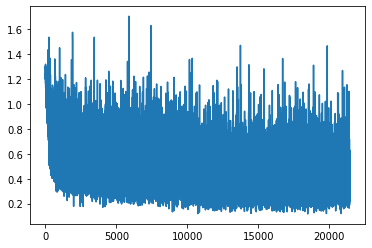

In [25]:
plt.plot(lh1)

In [26]:
lh2, optim2 = train2(M1, M2, tokenizer, epochs=2, learning_rate=1e-5, optimizer=optim2, loss_history=lh2, steps_per_update=steps_per_update)

<ipython-input-4-979a650b9590>:120: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Streaming output truncated to the last 5000 lines.
epoch: 1/2, 6030/10727, 3459s 574ms/step, lr: 1e-05, loss: 2.38
epoch: 1/2, 6031/10727, 3460s 574ms/step, lr: 1e-05, loss: 2.38
epoch: 1/2, 6032/10727, 3461s 574ms/step, lr: 1e-05, loss: 2.38
epoch: 1/2, 6033/10727, 3461s 574ms/step, lr: 1e-05, loss: 2.38
epoch: 1/2, 6034/10727, 3462s 574ms/step, lr: 1e-05, loss: 2.38
epoch: 1/2, 6035/10727, 3462s 574ms/step, lr: 1e-05, loss: 2.38
epoch: 1/2, 6036/10727, 3463s 574ms/step, lr: 1e-05, loss: 2.38
epoch: 1/2, 6037/10727, 3463s 574ms/step, lr: 1e-05, loss: 2.38
epoch: 1/2, 6038/10727, 3464s 574ms/step, lr: 1e-05, loss: 2.38
epoch: 1/2, 6039/10727, 3464s 574ms/step, lr: 1e-05, loss: 2.38
epoch: 1/2, 6040/10727, 3465s 574ms/step, lr: 1e-05, loss: 2.38
epoch: 1/2, 6041/10727, 3466s 574ms/step, lr: 1e-05, loss: 2.38
epoch: 1/2, 6042/10727, 3466s 574ms/step, lr: 1e-05, loss: 2.38
epoch: 1/2, 6043/10727, 3467s 574ms/step, lr: 1e-05, loss: 2.38
epoch: 1/2, 6044/10727, 3467s 574ms/step, lr: 1e-05, 

KeyboardInterrupt: ignored

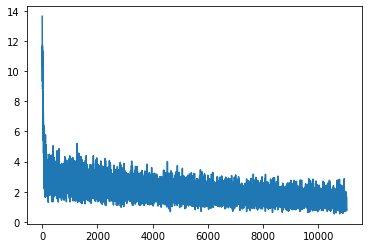

In [27]:
plt.plot(lh2)

In [28]:
torch.cuda.empty_cache()

In [ ]:
lh3, optim3 = train2(M1, M2, tokenizer, epochs=1, learning_rate=1e-5, optimizer=optim3, loss_history=lh3, train_M1=True, steps_per_update=steps_per_update, steps_empty_cache=steps_empty_cache)

In [ ]:
plt.plot(lh3)

In [42]:
def f_PQ(M1, M2, tokenizer, passage, question, generation_params=None):
    M2.to('cuda')
    inputs = tokenizer(
            question,
            passage,
            max_length=512,
            truncation=True,
            padding=True,
            return_tensors="pt",
        ).to('cuda')

    if generation_params is None:
        generation_params = {
            'do_sample' : False,
            'num_beams' : 3,
            'repetition_penalty' : 2.
        }

    with torch.no_grad():
        O1 = M1.forward(inputs.input_ids,
                        inputs.attention_mask)

        generated_ids = M2.generate(inputs.input_ids, token_importances=O1, **generation_params)

        generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_text

In [46]:
i=random.randint(0,len(train))

passage = train[i]['story']
question = train[i]['questions'][0]['input_text']
answer = train[i]['answers'][0]['input_text']

print('passage: ',passage)
print()
print('question: ',question)
print()
print('Original answer: ',answer)

print()
print(f_PQ(M1, M2, tokenizer, passage, question))


passage:  Seedy the watermelon was a very special type of watermelon. He didn't have any seeds. He was green and he had stripes. All of his cousins had seeds, but he didn't have any. He felt very left out. He couldn't thing of why he was different. His mom told him it was because he was a very special watermelon. She also tells him she loves him the way he is. But Seedy didn't think it was a good thing. He wished he could be like everyone else and have seeds. One day, he rolled out to the lawn and looked at all of his new cousins growing in the garden. He rolled around until he found a little baby watermelon that didn't have any seeds either. He sat next to him and talked to him. He told him that he was very special, and was excited for him to be picked off the vine and be his special best friend. He would name him Seedy, Jr.

question:  How was Seedy different?

Original answer:  He didn't have any seeds.

because he was a little bit


In [45]:
i=random.randint(0,len(validation))

passage = validation[i]['story']
question = validation[i]['questions'][0]['input_text']
answer = validation[i]['answers'][0]['input_text']

print('passage: ',passage)
print()
print('question: ',question)
print()
print('Original answer: ',answer)

print()
print(f_PQ(M1, M2, tokenizer, passage, question))


passage:  Jim rode his bike quickly. It was Friday and he wanted to get to the lake. The path to the lake was long and winding. It was wetter on Tuesday. Jim had to wash his boot. His boot had once been frozen. It was frozen because he left it outside on Sunday. He had to leave his boot outside for a long time. The lake was facing the tree. Jim had to go home. He wanted food very badly. Jim went home. He got inside and looked up at the ceiling. He walked to the refrigerator. Jim took the yogurt out of the refrigerator. Some milk was on the table and he grabbed a cup so he could pour himself some of the milk. Jim also had a candy bar. Jim sat down and rested. He was tired from the long bike ride. He finished his yogurt and began planning his next trip to the lake. It would not be long before he returned. He and his boots were ready for more fun outdoors Monday.

question:  What'd Jim ride?

Original answer:  his bike

a bike
